# Machine learning algorithm

In [258]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, validation_curve, train_test_split
from statistics import mean
from numpy import std
import re
from packages.adspy_shared_utilities import plot_feature_importances

In [5]:
# LOAD THE DATA
# use pandas to read data as table
# index is already specified in *.txt file -> use first column as index column
artworks = pd.read_table("beautified_boxes_numeric.txt", index_col=0)
artworks

,Artwork-Id,type,district,environment,countArtists,experience,replaced,content,userRating,approval
0,32048698,5,3,3,2,1,7,2,4,1
1,39800694,5,3,3,3,2,4,1,2,0
2,80318972,4,3,2,3,2,8,2,4,0
3,74478002,4,3,3,4,1,3,2,4,0
4,71449602,5,2,4,3,2,4,2,0,0
...,...,...,...,...,...,...,...,...,...,...
745,68311402,5,4,4,2,1,6,1,3,1
746,22390811,5,1,3,2,2,6,2,5,1
747,19230282,5,5,3,1,3,6,2,5,1
748,29644044,5,3,4,2,3,8,2,3,1


In [6]:
# SET FEATURES AND LABEL

# set features and label
# features (X): "type", "district", "environment", "countArtists", "experience", "replaced", "content", "userRating"
# label (y): "approval"
# do not use for classification: "Artwork_Id"
X = artworks[["type", "district", "environment", "countArtists", "experience", "replaced", "content", "userRating"]]
y = artworks["approval"]


In [232]:
# DETERMINE OPTIMUM DEPTH OF DECISION TREE CLASSIFIER
# calculate accuracy for depths 1 to 20 for a total of 1000 times, later on, average this to get reliable values (mostly) independent from individual train-test-splits

# make empty data frame to contain all of the averaged test data later on
tree_depth_data_complete_cols = {}
tree_depth_data_complete = pd.DataFrame(tree_depth_data_complete_cols)

# determine optimum depth 1000 times in total
for i in range(1, 1001):
    
    # each time, do an individual train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # make empty data frame to contain test data for 1 iteration
    # name columns after accuracy on train or rather split and add number of iteration
    tree_depth_cols = {"accuracy_train_" + str(i): [], "accuracy_train_" + str(i): []}
    tree_depth_data = pd.DataFrame(tree_depth_cols)
    # df for numerical value of depth
    depth_cols = {"depth": []}
    depth_data = pd.DataFrame(depth_cols)

    # evaluate accuracy for depths 1 to 20
    # for each depth, make a tree classifier, train it and evaluate accuracy on training as well as test set
    # then append this data to the main data frame
    for n in range(1, 21):
        tree_depth_test = DecisionTreeClassifier(max_depth = n).fit(X_train, y_train)
        # extract numerical value of depth
        depth = {"depth": [n]}
        append_depth = pd.DataFrame(depth)
        depth_data = pd.concat([depth_data, append_depth])
        # append the results to the df
        test_data = {"accuracy_train_" + str(i): [(tree_depth_test.score(X_train, y_train))], "accuracy_test_" + str(i): [(tree_depth_test.score(X_test, y_test))]}
        append_data = pd.DataFrame(test_data)
        tree_depth_data = pd.concat([tree_depth_data, append_data])
    
    # add data of each iteration to the df
    # add depth to df only in first iteration
    if i == 1:
        tree_depth_data_complete = pd.concat([depth_data, tree_depth_data_complete, tree_depth_data], axis=1)
    else:
        tree_depth_data_complete = pd.concat([tree_depth_data_complete, tree_depth_data], axis=1)


# set depth column as index and have a look at the data frame
tree_depth_data_complete = tree_depth_data_complete.set_index("depth")

In [241]:
# CALCULATE MEANS OF RESULTS
# there were 1000 train-test-splits now and accuracy of tree classifiers were calculated for 20 different depths now
# to minimize influence of coincidence, the mean is calculated

# get number of columns of data frame
ncols = tree_depth_data_complete.shape[1]

# calculate means of accuracy on train data
averages_train = tree_depth_data_complete.iloc[:, range(0, (ncols - 1), 2)].mean(axis=1)

# calculate means of accuracy on test data
averages_test = tree_depth_data_complete.iloc[:, range(1, ncols, 2)].mean(axis=1)

# make a column for starting from 1 (as opposed to 0 based indexing in python)
depth_index = range(1, (tree_depth_data_complete.shape[0] + 1))

# combine to a df, set depth as index, then have a look at it
means = pd.DataFrame({"depth": depth_index , "train": averages_train, "test": averages_test}).set_index("depth")
means

,train,test
depth,,
1,0.717931,0.720213
2,0.755842,0.732303
3,0.783313,0.741505
4,0.825004,0.769271
5,0.858418,0.785404
6,0.895879,0.793309
7,0.928181,0.793293
8,0.954498,0.790457
9,0.973185,0.785984


On average over 1000 iterations, a depth of 6 yields the highest accuracy of 0.7933085106382989


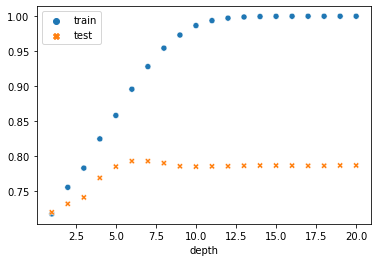

In [262]:
# PLOT THE RESULTS OF THE TEST AND PRINT BEST AVERAGE DEPTH/ACCURACY
sns.scatterplot(data=means)
print("On average over 1000 iterations, a depth of", means.index[means["test"] == max(means["test"])].tolist()[0], "yields the highest accuracy of", max(means["test"]))

In [269]:
# CREATE AND TRAIN DECISION TREE CLASSIFIER OBJECT
# determined from test: depth of 6 yields best average accuracy on test set -> decide for maximum depth of 6

# do train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# create and train classifier
tree = DecisionTreeClassifier(max_depth = 6).fit(X_train, y_train)

In [270]:
# DETERMINE AND PRINT ACCURACY OF CLASSIFIER

print('Accuracy of Decision Tree classifier on training set: {:.0f}'
     .format(tree.score(X_train, y_train) * 100), "%.")
print('Accuracy of Decision Tree classifier on test set: {:.4f}'
     .format(tree.score(X_test, y_test) * 100), "%.")

Accuracy of Decision Tree classifier on training set: 88 %.
Accuracy of Decision Tree classifier on test set: 83.5106 %.


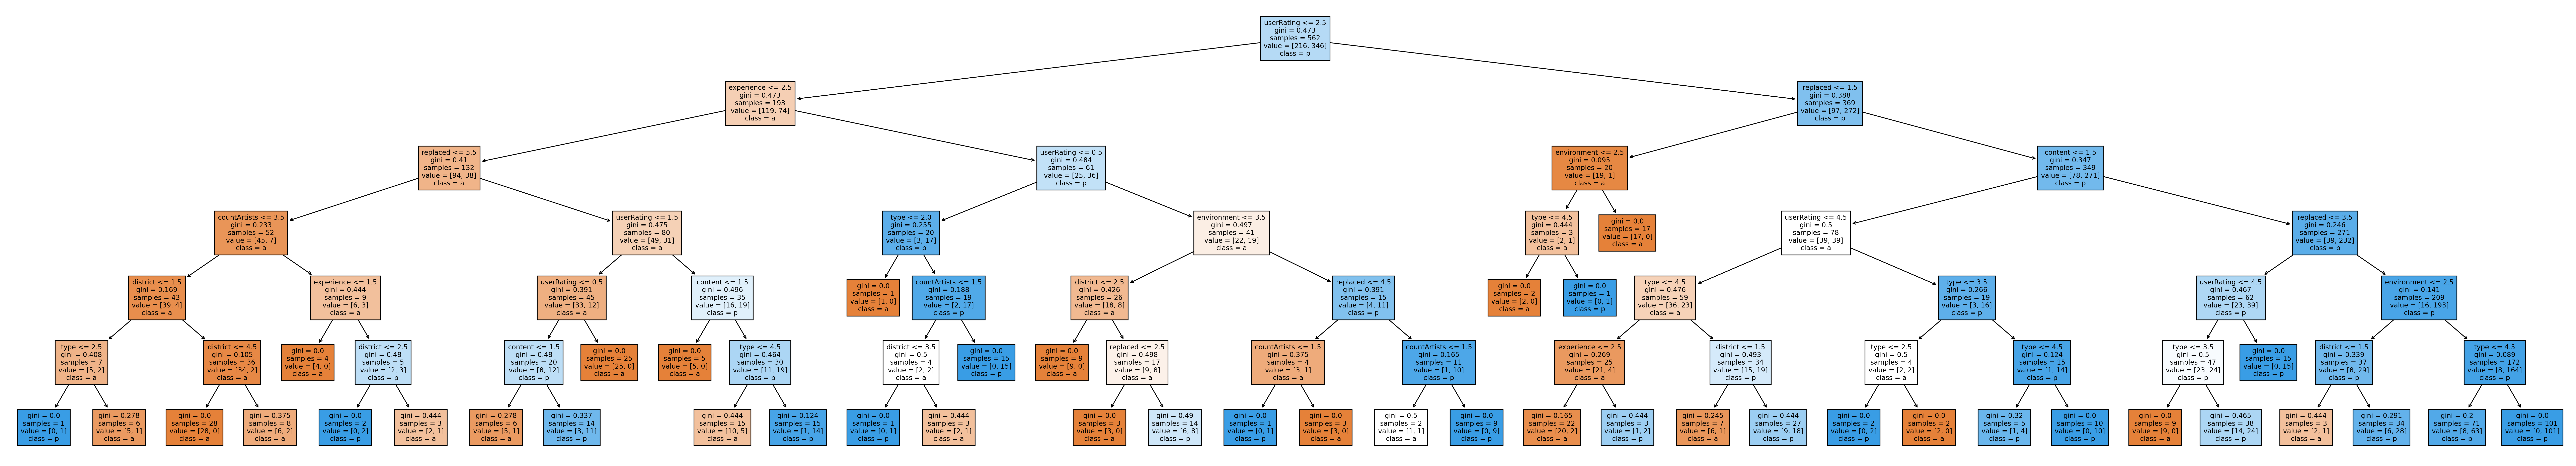

In [271]:
# VISUALISE THE DECISION TREE CLASSIFIER
# please note: the solution is really bad if displayed within notebook
# please expand the image to view high solution image

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (55,10), dpi=300)
plot_tree(tree, feature_names=X_train.columns, class_names=y_train.name, filled=True, fontsize=8);

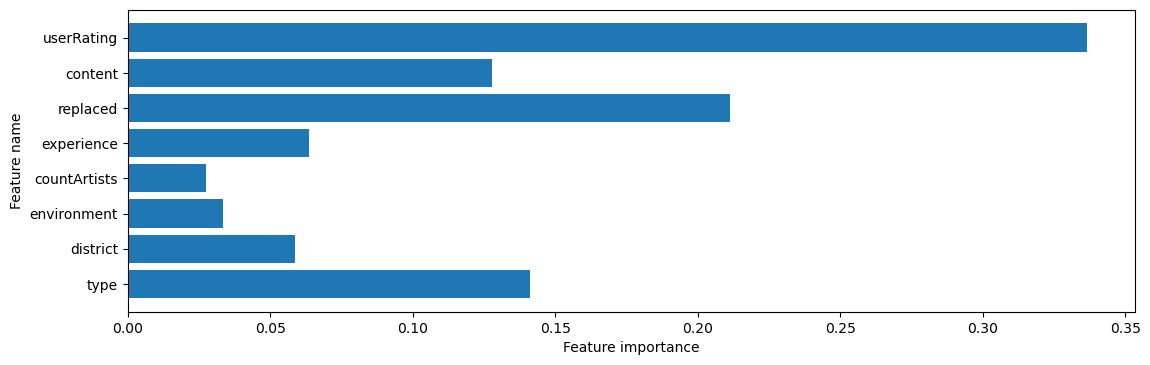

Feature importances: [0.14114428 0.05863692 0.03343723 0.02757849 0.06362981 0.21133047
 0.12765008 0.33659271]


In [278]:
# PLOT FEATURE IMPORTANCE

plt.figure(figsize=(13,4), dpi=100)
plot_feature_importances(tree, X_train.columns)
plt.show()

print('Feature importances: {}'.format(tree.feature_importances_))


In [288]:
# USE THE TRAINED CLASSIFIER TO CLASSIFY NEW PREVIOUSLY UNSEEN OBJECTS

application1 = [4, 5, 2, 4, 1, 3, 3, 1]
application2 = [4, 5, 2, 2, 4, 4, 3, 5]

def treepredict(application):
    outcome = tree.predict([application])
    if outcome[0] == 1:
        print("Approved")
    elif outcome[0] == 0:
        print("Not approved")
    else:
        print("Wrong data format")
    #return outcome

treepredict(application1)
treepredict(application2)

Not approved
Approved
